<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/Bunkruptcy-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Kaggle dataset**

## Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データセットの準備
Kaggleと同じコードで動くよう、フォルダの関係を調整

In [2]:
import os
import shutil

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle



os.makedirs("./input/bankruptcy-risk-prediction", exist_ok=True)
os.makedirs("./output", exist_ok=True)

# zipファイルのダウンロード
!kaggle competitions download -c bankruptcy-risk-prediction -p /content
# 解凍
!unzip ./bankruptcy-risk-prediction.zip -d ./input/bankruptcy-risk-prediction

#Zipフォルダを削除
!rm ./bankruptcy-risk-prediction.zip

#作業フォルダを作成

os.makedirs("./Kaggle", exist_ok=True)
os.chdir("./Kaggle")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 11.9MB/s]
Archive:  ./bankruptcy-risk-prediction.zip
replace ./input/bankruptcy-risk-prediction/submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



#**Load data**

In [198]:
# load train.csv
train_df = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')

# load test.csv
test_df = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

# load submission_example.csv
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')


print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')
print(f'submission.shape = {submission.shape}')

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 1000)

train_df
test_df

train_df.shape = (800, 22)
test_df.shape = (200, 21)
submission.shape = (200, 2)


,id,sum,term,payment,guarantees,reason,credits,other_credits,credit_report,marital_status,age,employment,qualification,immigrant,residence_since,accommodation,estate,savings,dependents,phone,status
0,800,1597,24,4,none,education,2,none,critical account or other credits existing(not...,male single,54,7+ y.,skilled employee,yes,4,for free,unknown or no property,less-than 100 cu,2,none,no checking account
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,999,4576,45,3,none,used car,1,none,critical account or other credits existing(not...,male single,27,unemployed,skilled employee,yes,4,own,car or other,100 to 500 cu,1,none,0 to 200 cu


In [ ]:
# #Profiling用。Runtimeの再起動を要求されるので先にインポートしておく
# !pip install pandas-profiling
# !pip install -U pandas_profiling
# !pip uninstall markupsafe
# !pip install markupsafe==2.0.1 #エラー対応

# import pandas as pd
# import pandas_profiling as pdp

# pdp.ProfileReport(train_df)


In [ ]:
# check data type(train_data)
print(train_df.dtypes)

# check missing values (train_data)
print(train_df.isnull().sum())

# check missing values (test_data)
print(test_df.isnull().sum())

In [ ]:
# check train_data describe
train_df.describe().T

In [ ]:
#Object項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
#categories

sns.set()

fig, axes = plt.subplots(len(categories_obj),1,figsize=(9,9*len(categories_obj)))   

for i in range(len(categories_obj)):
    sns.barplot(x=categories_obj[i], y="bankruptcy", data=train_df, palette="Set3", ax=axes[i])

plt.show()


for j in range(len(categories_obj)):
    print(train_df.groupby(categories_obj[j]).count().index.to_list())


In [ ]:
#Object以外の項目の分布図を縦に並べて表示
import seaborn as sns
import matplotlib.pyplot as plt

categories_float = train_df.columns[train_df.dtypes=='int64']

sns.set()
#fig, axes = plt.subplots(len(categories),1,figsize=(9,9*len(categories)))   

for i in range(len(categories_float)):
    fare = sns.FacetGrid(train_df, hue="bankruptcy",aspect=2)
    fare.map(sns.kdeplot,categories_float[i],shade= True)
    fare.set(xlim=(0, train_df[categories_float[i]].max()))
    fare.add_legend()
plt.show()


for j in range(len(categories_float)):
    print(train_df.groupby(categories_float[j]).count().index.to_list())


#**PyCaret**

In [17]:
train_df.columns

Index(['id', 'sum', 'term', 'payment', 'guarantees', 'reason', 'credits',
       'other_credits', 'credit_report', 'marital_status', 'age', 'employment',
       'qualification', 'immigrant', 'residence_since', 'accommodation',
       'estate', 'savings', 'dependents', 'phone', 'status', 'bankruptcy'],
      dtype='object')

In [ ]:
!pip install pycaret
!pip install pandas-profiling==3.1.0

In [40]:
train_df.shape

(800, 22)

In [19]:
# init setup
from pycaret.classification import *
categorical_feautres = []
s = setup(data = train_df, target = 'bankruptcy', categorical_features=[], numeric_features=['sum', 'term', 'payment', 'guarantees', 'reason', 'credits', 'other_credits', 'credit_report', 'marital_status', 'age', 'employment', 'qualification', 'immigrant', 'residence_since', 'accommodation', 'estate', 'savings', 'dependents', 'phone', 'status'], session_id=123)
#s = setup(data = train_df, target = 'bankruptcy', session_id=123)

,Description,Value
0,session_id,123
1,Target,bankruptcy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(800, 22)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=['id'],
                                      ml_usecase='classification',
                                      numerical_features=['sum', 'term',
                                                          'payment',
                                                          'guarantees',
                                                          'reason', 'credits',
                                                          'other_credits',
                                                          'credit_report',
                                                          'marital_status',
                                                      

In [20]:
best_model = compare_models(sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7710,0.7989,0.5176,0.6715,0.5768,0.4241,0.4361,0.016
rf,Random Forest Classifier,0.7835,0.7977,0.4463,0.7559,0.5549,0.4236,0.4533,0.488
nb,Naive Bayes,0.7549,0.7869,0.4099,0.6573,0.4917,0.3451,0.3676,0.015
lightgbm,Light Gradient Boosting Machine,0.7495,0.7792,0.4816,0.6218,0.5361,0.3692,0.3790,0.114
qda,Quadratic Discriminant Analysis,0.7012,0.7731,0.6364,0.5355,0.5726,0.3542,0.3576,0.016
gbc,Gradient Boosting Classifier,0.7639,0.7699,0.4761,0.6602,0.5467,0.3937,0.4072,0.119
et,Extra Trees Classifier,0.7460,0.7684,0.3930,0.6502,0.4802,0.3257,0.3491,0.463
ada,Ada Boost Classifier,0.7406,0.7351,0.4651,0.6157,0.5086,0.3424,0.3599,0.103
lr,Logistic Regression,0.7209,0.7227,0.2320,0.6008,0.3272,0.1953,0.2322,0.344
dt,Decision Tree Classifier,0.6728,0.6092,0.4482,0.4707,0.4505,0.2214,0.2262,0.015


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
INFO:logs:compare_models() succesfully completed......................................


In [21]:
print(best_model)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [22]:
lda = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7143,0.7315,0.3529,0.5455,0.4286,0.2496,0.2601
1,0.8036,0.8839,0.5294,0.7500,0.6207,0.4934,0.5070
2,0.7857,0.7481,0.4118,0.7778,0.5385,0.4157,0.4513
3,0.6607,0.6471,0.5294,0.4500,0.4865,0.2356,0.2374
4,0.7857,0.8839,0.4706,0.7273,0.5714,0.4372,0.4556
5,0.7857,0.7722,0.5882,0.6667,0.6250,0.4758,0.4776
6,0.7857,0.7949,0.5294,0.6923,0.6000,0.4572,0.4649
7,0.7143,0.7270,0.5294,0.5294,0.5294,0.3243,0.3243
8,0.7321,0.7953,0.5000,0.5333,0.5161,0.3312,0.3315


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [23]:
tuned_lda = tune_model(lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7679,0.7647,0.4706,0.6667,0.5517,0.4013,0.4124
1,0.7857,0.8612,0.4706,0.7273,0.5714,0.4372,0.4556
2,0.8214,0.7526,0.5294,0.8182,0.6429,0.5310,0.5533
3,0.7679,0.7044,0.6471,0.6111,0.6286,0.4599,0.4603
4,0.7679,0.8265,0.4706,0.6667,0.5517,0.4013,0.4124
5,0.7679,0.7979,0.6471,0.6111,0.6286,0.4599,0.4603
6,0.8036,0.7602,0.6471,0.6875,0.6667,0.5276,0.5281
7,0.6607,0.7391,0.4118,0.4375,0.4242,0.1840,0.1842
8,0.8036,0.7437,0.5000,0.7273,0.5926,0.4690,0.4833


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


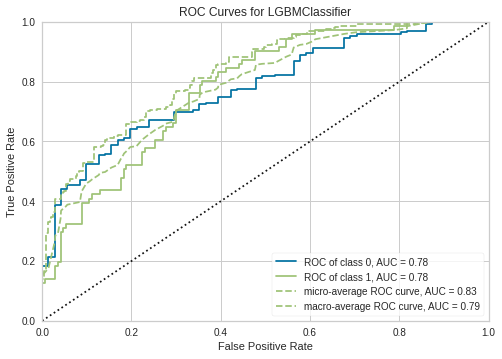

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [24]:
plot_model(tuned_lda, plot = 'auc')


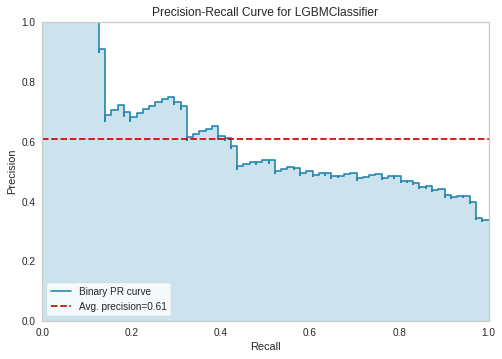

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [25]:
plot_model(tuned_lda, plot = 'pr')


In [ ]:
plot_model(tuned_lda, plot='feature')

In [ ]:
plot_model(tuned_lda, plot = 'confusion_matrix')


In [ ]:
predict_model(tuned_lda);

In [ ]:
# finalize rf model
final_lda = finalize_model(tuned_lda)

predict_model(final_lda);


In [ ]:
unseen_predictions = predict_model(final_lda, data=test_df)


In [ ]:
unseen_predictions

#**Data processing**

In [ ]:
#nominal to proportional scale (名義尺度→連続尺度)
categories_obj = train_df.columns[train_df.dtypes=='object'].values.tolist()
categories_obj.extend(["dependents", "residence_since", "credits", "payment"])

for obj in categories_obj:
    rate = train_df.groupby(obj).mean()["bankruptcy"].tolist() #show rate of bankruptcy in each nominal indices
    indices = train_df.groupby(obj).count().index.to_list()

    # print(rate)
    # print("")
    
    #index (=nominal scale) to rate (=proportional scale)
    for i in range(len(rate)):
        train_df[obj] = train_df[obj].replace(indices[i], rate[i])
        test_df[obj] = test_df[obj].replace(indices[i], rate[i])

train_df

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# obtain object data type as list (outcomeが数値でないラベルを抜き出す)
categories = train_df.columns[train_df.dtypes=='object'].values.tolist()

# One-hot Encoding
for cat in categories:
    
    # generate Label Encoder object
    train_df_encoder = pd.get_dummies(train_df[[cat]])
    test_df_encoder = pd.get_dummies(test_df[[cat]])

    #concat 
    train_df = pd.concat([train_df, train_df_encoder],axis=1)
    test_df = pd.concat([test_df, test_df_encoder], axis=1)
    
    #drop original (object data) categories
    train_df.drop(cat, axis=1, inplace=True)
    test_df.drop(cat, axis=1, inplace=True)

#drop duplicated columns
train_df.loc[:,~train_df.columns.duplicated()]
test_df.loc[:,~test_df.columns.duplicated()]

#**Neural network_Pytorch**

In [251]:
#Dataset

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.iloc[:, 0:20].apply(scipy.stats.zscore, axis=0)

In [239]:
#Split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
x_train.shape

(640, 20)

In [240]:
#Define the model 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #Note that x_train.shape[1]=20 is the number of columns in the input matrix. 
        self.fc1 = nn.Linear(x_train.shape[1], 270)
        #270 is arbitrary, but needs to be consistent.  2 is the number of classes in the output (died/survived)
        self.fc2 = nn.Linear(270, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  #signmoid flattens to probability 0-1. 
        
        return x
    
net = Net()

In [241]:
#Define training
batch_size = 50
num_epochs = 100
learning_rate = 0.01
batch_no = len(x_train) // batch_size

#define loss function and optimizer 
#Adam is a specific flavor of gradient decent which is typically better
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable
running_loss = 0.0
for epoch in range(num_epochs):
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(x_train[start:end].values))
        labels = Variable(torch.LongTensor(y_train[start:end].values))
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
    running_loss = 0.0


In [243]:
test_df.shape

(200, 21)

Accuracy 0.94 for a total of  640 records
Accuracy 0.75 for a total of  160 records
Area_under_ROC : 0.908628136569313
Area_under_ROC : 0.7222791555646648
returning predictions


array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0])

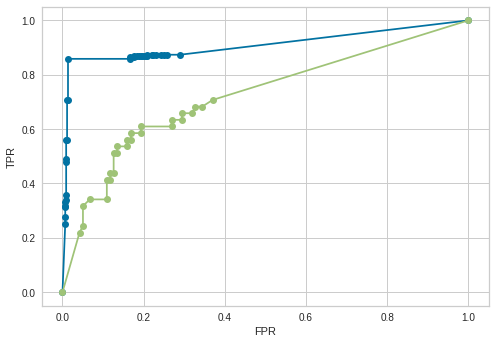

In [244]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#This is a little bit tricky to get the resulting prediction.  
def calculate_accuracy(x,y=[]):
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x.values), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
  values, labels = torch.max(output, 1)
  if len(y) != 0:
      num_right = np.sum(labels.data.numpy() == y)
      print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
  else:
      print("returning predictions")
      return labels.data.numpy()

def calculate_roc(x, y=[]):
  labels, probs = [], [] 
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x.values), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
      prob = nn.Softmax(dim=1)(output) #calculate probalility
  labels = y.values
  probs = [i[1] for i in prob]
  fpr, tpr, thresholds = roc_curve(labels, probs)     
  plt.plot(fpr, tpr, marker='o')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  print(f'Area_under_ROC : {roc_auc_score(labels, probs)}')
  #plt.savefig('plots/roc_curve.png')
    
# Check out the accuracy. 
calculate_accuracy(x_train, y_train)
calculate_accuracy(x_val, y_val)
calculate_roc(x_train, y_train)
calculate_roc(x_val, y_val)

predictions=calculate_accuracy(test_df.iloc[:,0:20])
len(predictions)
predictions

In [245]:
#Writing to File
submission=pd.DataFrame(test_df.loc[:,['id']])
submission['proba']=predictions
#Any files you save will be available in the output tab below

submission.to_csv('submission.csv', index=False)

In [246]:
!pip install ranger_adabelief
from ranger_adabelief import RangerAdaBelief

import numpy as np
import torch
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

class DataSet(torch.utils.data.Dataset):
	def __init__(self, data, label):

		self.data = data
		self.label = label
		self.length = len(data)

	def __len__(self):

		return self.length

	def __getitem__(self, idx):

		data = self.data[idx]
		label = self.label[idx]

		return data, label




class EarlyStopping:

    def __init__(self, patience=20, verbose=False):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.force_cancel = False

    def __call__(self, val_loss, model):
        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/Kaggle/model.pth')
        self.val_loss_min = val_loss


def training(model):
  for epoch in range(EPOCHS):

    train_loss = 0
    train_acc = 0
    total = 0
    model.train()
    
    for inputs, labels in trainloader:

      optimizer.zero_grad()

      output = model(inputs.float())
      predicted = torch.argmax(output, axis=1)

      target = labels

      loss = criterion(output, target)

      train_loss += loss.item()
      train_acc += (predicted == target).sum().item()

      total += labels.size(0)

      loss.backward()
      optimizer.step()

    train_loss = train_loss / total
    train_acc = train_acc / total
    
    print("train_acc:", str(train_acc))
    model.eval()
    vali_total = 0
    vali_loss = 0
    vali_acc = 0

    for data in validloader:

      with torch.no_grad():
        out = model.forward(inputs.float())
        predicted = torch.argmax(out, axis=1)

      target = data[1]

      loss = criterion(out, data[1])

      vali_loss += loss.item()
      vali_acc += (predicted == target).sum().item()
      vali_total += labels.size(0)

    vali_loss = vali_loss / vali_total
    vali_acc = vali_acc / vali_total
    
    
    print("valid_acc:", str(vali_acc))
    
    earlystopping(vali_loss, model)
    if earlystopping.early_stop:
      print("Early stopping")
      break


class SimpleNet(nn.Module):
	def __init__(self):
		super(SimpleNet, self).__init__()

		self.linear1 = nn.Linear(20, 30)
		self.linear2 = nn.Linear(30, 2)

	def forward(self, x):
		batch_size = x.shape[0]

		x = self.linear1(x)
		x = F.relu(x)
		x = self.linear2(x)
		x = F.sigmoid(x)
		out = torch.log_softmax(x, dim=1)
		return out

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# HyperParameter
LEARNING_RATE = 0.0001
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 5
EPOCHS = 1000

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)



x_train, x_val, y_train, y_val = train_test_split(X.values, y.values, test_size = 0.2, random_state=123, stratify=y.values)
model_ft = SimpleNet()
earlystopping = EarlyStopping()
criterion = nn.CrossEntropyLoss()


#optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)

optimizer = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

trainset = DataSet(x_train, y_train)
validset = DataSet(x_val, y_val)
trainloader = torch.utils.data.DataLoader(
	trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(
	validset, batch_size=VALID_BATCH_SIZE, shuffle=True)



for epoch in range(EPOCHS):

    train_loss = 0
    train_acc = 0
    total = 0
    model_ft.train()
    
    for inputs, labels in trainloader:
      optimizer.zero_grad()

      output = model_ft(inputs.float())
      predicted = torch.argmax(output, axis=1)

      target = labels

      loss = criterion(output, target)

      train_loss += loss.item()
      train_acc += (predicted == target).sum().item()

      total += inputs.size(0)

      loss.backward()
      optimizer.step()

    train_loss = train_loss / total
    train_acc = train_acc / total
    
    model_ft.eval()
    vali_total = 0
    vali_loss = 0
    vali_acc = 0

    for data in validloader:

      with torch.no_grad():
        out = model_ft.forward(inputs.float())
        predicted = torch.argmax(out, axis=1)

      target = labels

      loss = criterion(out, labels)

      vali_loss += loss.item()
      vali_acc += (predicted == target).sum().item()
      vali_total += labels.size(0)

    vali_loss = vali_loss / vali_total
    vali_acc = vali_acc / vali_total
    
    print("")
    print(f"epoch: {epoch+1}")
    print(f"train loss: {train_loss}, train_acc: {train_acc}")
    print(f"valid_loss: {vali_loss}, valid_acc: {vali_acc}")
    
    earlystopping(vali_loss, model_ft)
    if earlystopping.early_stop:
      print("Early stopping")
      break

In [248]:
#5-fold crossvalidation
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, KFold
import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)



dataset = DataSet(X, y)

batch_size = 16
kf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=0)

cv = 0
for _fold, (train_index, valid_index) in enumerate(kf.split(X.values, y.values)):
    train_dataset = Subset(dataset, train_index)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    valid_dataset   = Subset(dataset, valid_index)
    valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False)

    for i in range(num_epochs):
        # ここに学習コード
        model_ft = SimpleNet()
        earlystopping = EarlyStopping()
        criterion = nn.CrossEntropyLoss()


        #optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LEARNING_RATE)

        optimizer = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

        trainset = DataSet(x_train, y_train)
        validset = DataSet(x_val, y_val)
        trainloader = torch.utils.data.DataLoader(
          trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(
          validset, batch_size=VALID_BATCH_SIZE, shuffle=True)



        for epoch in range(EPOCHS):

            train_loss = 0
            train_acc = 0
            total = 0
            model_ft.train()
            
            for inputs, labels in trainloader:
              optimizer.zero_grad()

              output = model_ft(inputs.float())
              predicted = torch.argmax(output, axis=1)

              target = labels

              loss = criterion(output, target)

              train_loss += loss.item()
              train_acc += (predicted == target).sum().item()

              total += inputs.size(0)

              loss.backward()
              optimizer.step()

            train_loss = train_loss / total
            train_acc = train_acc / total
            
            model_ft.eval()
            vali_total = 0
            vali_loss = 0
            vali_acc = 0

            for data in validloader:

              with torch.no_grad():
                out = model_ft.forward(inputs.float())
                predicted = torch.argmax(out, axis=1)

              target = labels

              loss = criterion(out, labels)

              vali_loss += loss.item()
              vali_acc += (predicted == target).sum().item()
              vali_total += labels.size(0)

            vali_loss = vali_loss / vali_total
            vali_acc = vali_acc / vali_total
            
            print("")
            print(f"epoch: {epoch+1}")
            # print(f"train loss: {train_loss}, train_acc: {train_acc}")
            # print(f"valid_loss: {vali_loss}, valid_acc: {vali_acc}")
            
            
            # Evaluate the model with the test set.
            labels, probs = [], []  
            test_var = Variable(torch.FloatTensor(x_val), requires_grad=True)
            with torch.no_grad():   
                output = net(test_var) #This outputs the probability for each class.
                prob = nn.Softmax(dim=1)(output) #calculate probalility
            labels = y_val
            probs = [i[1] for i in prob]
            fpr, tpr, thresholds = roc_curve(labels, probs)     
            # plt.plot(fpr, tpr, marker='o')
            # plt.xlabel('FPR')
            # plt.ylabel('TPR')
            # plt.grid()
            print(f'Area_under_ROC : {roc_auc_score(labels, probs)}')


            earlystopping(vali_loss, model_ft)
            if earlystopping.early_stop:
              print("Early stopping")
              break

    # cv += valid_loss / kf.n_splits

ストリーミング出力は最後の 5000 行に切り捨てられました。
EarlyStopping counter: 8 out of 20

epoch: 61
Area_under_ROC : 0.7895275297619048
EarlyStopping counter: 9 out of 20

epoch: 62
Area_under_ROC : 0.7745535714285714
EarlyStopping counter: 10 out of 20

epoch: 63
Area_under_ROC : 0.7838541666666665
EarlyStopping counter: 11 out of 20

epoch: 64
Area_under_ROC : 0.7793898809523809

epoch: 65
Area_under_ROC : 0.7759486607142858
EarlyStopping counter: 1 out of 20

epoch: 66
Area_under_ROC : 0.7887834821428572
EarlyStopping counter: 2 out of 20

epoch: 67
Area_under_ROC : 0.7820870535714286
EarlyStopping counter: 3 out of 20

epoch: 68
Area_under_ROC : 0.7833891369047619
EarlyStopping counter: 4 out of 20

epoch: 69
Area_under_ROC : 0.7843191964285714
EarlyStopping counter: 5 out of 20

epoch: 70
Area_under_ROC : 0.783203125
EarlyStopping counter: 6 out of 20

epoch: 71
Area_under_ROC : 0.7819940476190474
EarlyStopping counter: 7 out of 20

epoch: 72
Area_under_ROC : 0.7820870535714285
EarlyStopping counter: 8

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#This is a little bit tricky to get the resulting prediction.  
def calculate_accuracy(x,y=[]):
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
  values, labels = torch.max(output, 1)
  if len(y) != 0:
      num_right = np.sum(labels.data.numpy() == y)
      print('Accuracy {:.2f}'.format(num_right / len(y)), "for a total of ", len(y), "records")
  else:
      print("returning predictions")
      return labels.data.numpy()

def calculate_roc(x, y=[]):
  labels, probs = [], [] 
  # Evaluate the model with the test set. 
  test_var = Variable(torch.FloatTensor(x), requires_grad=True)
  with torch.no_grad():   
      output = net(test_var) #This outputs the probability for each class.
      prob = nn.Softmax(dim=1)(output) #calculate probalility
  labels = y
  probs = [i[1] for i in prob]
  fpr, tpr, thresholds = roc_curve(labels, probs)     
  plt.plot(fpr, tpr, marker='o')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.grid()
  print(f'Area_under_ROC : {roc_auc_score(labels, probs)}')
  #plt.savefig('plots/roc_curve.png')
    
# Check out the accuracy. 
calculate_accuracy(x_train, y_train)
calculate_accuracy(x_val, y_val)
calculate_roc(x_train, y_train)
calculate_roc(x_val, y_val)

predictions=calculate_accuracy(test_df.iloc[:,0:20].values)
len(predictions)
predictions

#**Sklearn.neural_network**

In [255]:
import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)


#Split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


(160, 20)

In [281]:
#正規化する
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X_train = scaler.transform(X)
Y_train = y
X_test = scaler.transform(test_df.iloc[:, 0:20])

#モデル作成
import numpy as np
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(alpha=0.1, hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive', max_iter=500, random_state=42, solver="lbfgs", early_stopping=True) 
clf = model.fit(X_train,Y_train) 
print(f"train_accuracy: {accuracy_score(y_train, clf.predict(x_train))}")
print(f"val_accuracy: {accuracy_score(y_val, clf.predict(x_val))}")

train_accuracy: 1.0
val_accuracy: 1.0


train_accuracy: 1.0
val_accuracy: 1.0


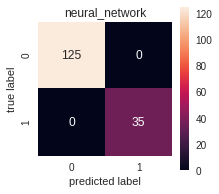

In [282]:
#accuracy
print(f"train_accuracy: {accuracy_score(y_train, clf.predict(x_train))}")
print(f"val_accuracy: {accuracy_score(y_val, clf.predict(x_val))}")

#confusion_matrix
cmx_data = confusion_matrix(y_val, clf.predict(x_val)) 
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize = (3,3))  
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("neural_network")  
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

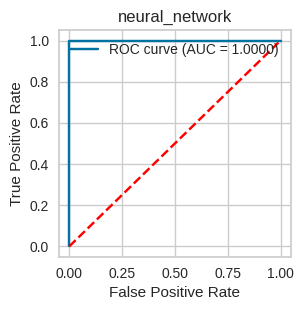

In [283]:
# -------- ROC曲線, AUC -----------
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, clf.predict_proba(x_val)[:, 0], pos_label=0) # 0:ガン患者の分類 
auc = roc_auc_score(y_val, clf.predict_proba(x_val)[:, 1])
plt.figure(figsize=(3, 3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)  
x = np.arange(0, 1, 0.01)  
plt.plot(x, x, c = 'red', linestyle = '--')  
plt.legend()
plt.title("neural_network")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [286]:
# obtain submission file from the prediction
submission['proba'] = clf.predict_proba(X_test)[:, 1]

# save submission
submission.to_csv('./submission.csv', index=False)

submission

,id,proba
0,-1.723412,1.000000e+00
...,...,...
199,1.723412,3.661963e-07


#**LightGBM**

In [63]:
#Dataset

import scipy.stats
from sklearn import preprocessing

# target label
y = train_df['bankruptcy']

# predictor features
X = train_df.drop(['id', 'bankruptcy'], axis=1)
X = X.apply(scipy.stats.zscore, axis=0) #standardization

# list of categorical features
category_list = X.columns[X.dtypes=='category'].values.tolist()

# standardize testset
test_df = test_df.apply(scipy.stats.zscore, axis=0)


In [67]:
from pandas._libs.tslibs.parsing import try_parse_date_and_time
# LightGBM / hyper parameters
lgbm_params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',                 # binary classification
    'metric': 'auc',                         # evaluator：AUC
    
    'learning_rate': 0.05, 
    
    'num_leaves': 32, 
    
    'n_estimators': 100000, 
    'importance_type': 'gain', 
    
    'random_state': 123, 
}

params = {
    'boosting_type': 'gbdt',            # Gradient Boosting Decision Tree
    'objective': 'binary',
    'verbose': -1,
    "metric" : "None",
    'learning_rate': 0.05, 
    'num_leaves': 32, 
    'n_estimators': 100000, 
    'importance_type': 'gain',  
    'random_state': 123, 
}

#custom_metrics
import sklearn
from sklearn.metrics import f1_score
import numpy as np
from sklearn import datasets
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
def f1(preds, data):
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metric = 2*precision*recall/(precision+recall)
    return 'f1', metric, True

def accuracy(preds, data):
    """精度 (Accuracy) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True


def precision(preds, data):
    """適合率 (Precision) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = precision_score(y_true, y_pred)
    return 'precision', metric, True


def recall(preds, data):
    """再現率 (Recall) を計算する関数"""
    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def prroc(preds, data):
    """AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    recall, precision, thresholds = precision_recall_curve(y_true, y_pred)
    metric = sklearn.metrics.auc(recall, precision)
    return 'prroc', metric, True

def aucroc(preds, data):
    """Precision_recall_AUC を計算する関数"""
    y_true = data.get_label()
    y_pred = preds
    metric = roc_auc_score(y_true, y_pred)
    return 'aucroc', metric, True


def metrics(preds, data): #複数onにすると、複数の指標でearly stoppingをしてしまうので注意
    """複数の評価指標を計算するための関数"""
    # リストでまとめて返せば良い
    return [
        accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1(preds, data),
        aucroc(preds, data),
        #prroc(preds, data), #これはうまくいかない
    ]

In [ ]:
#PythonAPI_lightGBM

from sklearn.metrics import log_loss


# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv =y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    # データセットを生成する
    lgb_train = lgb.Dataset(x_train_cv, y_train_cv)
    lgb_eval = lgb.Dataset(x_valid_cv, y_valid_cv, reference=lgb_train)

    # 上記のパラメータでモデルを学習する
    evals_result = {}
    model = lgb.train(params, lgb_train, 
                  #valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=50,
                  # メトリックを追跡する対象のデータセット
                  valid_sets=[lgb_eval, lgb_train],
                  #valid_sets=[lgb_eval],
                  # 上記の名前
                  valid_names=['eval', 'train'],
                  # メトリックの履歴を残すオブジェクト
                  evals_result=evals_result,
                  # 独自メトリックを計算する関数
                  feval=metrics,
                 )
    
    
    # predict data for model fitting
    y_pred_train = model.predict(x_train_cv)
    
    # predict validation data
    y_pred_valid = model.predict(x_valid_cv)
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)

    #calculate log_loss
    logloss = log_loss(y_valid_cv, y_pred_valid)

    print(f'\nfold: {n_fold}')
    print(f'log loss: {logloss}')
    
    # AUC
    print(f'auc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid

# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')
    

In [ ]:
#SKlearn_lightGBM

# StratifiedKFold-CV

# num of fold
folds = 5

# list of fixed models based on CV
models = []

# list of auc based on CV
auc = []

# prediction of valid data
out_of_fold = np.zeros(len(X))


# generate StratifiedKFold object and prepare train_index & valid_index
cv = list(StratifiedKFold(n_splits=folds, shuffle=True, random_state=123).split(X, y))


# CV
for n_fold in np.arange(folds):
    
    # obtain index for model fitting
    train_index = cv[n_fold][0]
    
    # obtain index for validation data
    valid_index = cv[n_fold][1]
    
    # predictor features for model fitting
    x_train_cv = X.iloc[train_index]
    
    # target label for model fitting
    y_train_cv = y.iloc[train_index]
    
    # predictor features for validation
    x_valid_cv = X.iloc[valid_index]
    
    # target label for validation
    y_valid_cv = y.iloc[valid_index]
    
    
    
    # generate LightGBM model object
    model = lgb.LGBMClassifier(**lgbm_params)
    
    
    # model fitting
    model.fit(
        x_train_cv, 
        y_train_cv, 
        eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
        early_stopping_rounds = 100, 
        categorical_feature = category_list,
        verbose = 50, 
    )
    
    
    # predict data for model fitting
    y_pred_train = model.predict_proba(x_train_cv, num_iteration=model.best_iteration_)[:, 1]
    
    # predict validation data
    y_pred_valid = model.predict_proba(x_valid_cv, num_iteration=model.best_iteration_)[:, 1]
    
    
    # AUC
    # data for model fitting
    temp_auc_train = roc_auc_score(y_train_cv, y_pred_train)
    
    # validation data
    temp_auc_valid = roc_auc_score(y_valid_cv, y_pred_valid)
    
    # AUC
    print(f'\nauc(train_data) = {temp_auc_train:.4f}')
    print(f'auc(valid_data) = {temp_auc_valid:.4f}\n')
    
    # AUC append
    auc.append([temp_auc_train, temp_auc_valid])
    
    
    # model append
    models.append(model)
    
    # prediction result of validation data
    out_of_fold[valid_index] = y_pred_valid
    
    
    # plot of model fitting curve
    lgb.plot_metric(model, ylim=(0, 1.2));

In [36]:
# auc into NumPy type
auc_np = np.array(auc)

# mean of auc (train data)
auc_train_mean = auc_np[:, 0].mean()
print(f'auc(train_data)_mean = {auc_train_mean:.4f}')

# mean of auc (validation data)
auc_valid_mean = auc_np[:, 1].mean()
print(f'auc(valid_data)_mean = {auc_valid_mean:.4f}')

auc(train_data)_mean = 0.9948
auc(valid_data)_mean = 0.7953


In [38]:
# Prediction of test data

# list of prediction based on each CV
preds_test = []


# predictor features of test data
x_test = test_df.drop(['id'], axis=1)


# predict with learned model based on CV
for model in models:
    
    # predict
    pred = model.predict_proba(x_test, num_iteration=model.best_iteration_)[:, 1]
    
    # append
    preds_test.append(pred)

In [ ]:
# preds_test into NumPy type
preds_test_np = np.array(preds_test)

# obtain its mean
preds_test_np_mean = preds_test_np.mean(axis=0)

# print
preds_test_np_mean

#**submission**

In [115]:
# obtain submission file from the prediction
submission['proba'] = preds_test_np_mean

submission

,id,proba
0,800,0.113787
...,...,...
199,999,0.393655


In [ ]:
# save submission
submission.to_csv('./submission.csv', index=False)

#**Specify important factors**

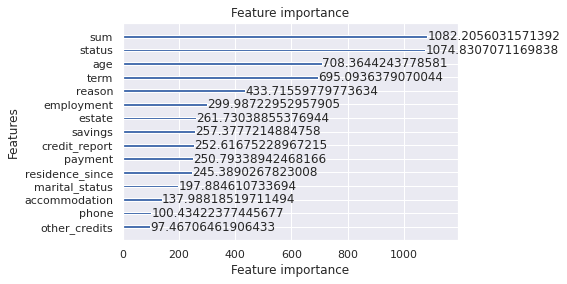

In [116]:
# important features
lgb.plot_importance(model, importance_type='gain', max_num_features=15)